In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-real-product-images/README.dataset.txt
/kaggle/input/fake-real-product-images/README.roboflow.txt
/kaggle/input/fake-real-product-images/valid/ab02wh-4-adibas-white-original-imaevfaghu73xwmn_jpg.rf.dedf1470c32734169ce190b46facc562.jpg
/kaggle/input/fake-real-product-images/valid/718chz6BFsL-_UX569__jpg.rf.24be0af2983c2480a5aeffae4cf22a3f.jpg
/kaggle/input/fake-real-product-images/valid/f3f04e65ef8f265b2b88880d79a64194_jpg.rf.4a2f371d8648deb88e9c85248dfb81e9.jpg
/kaggle/input/fake-real-product-images/valid/Fake-counterfeit-neppe-Nike-Air-Max-1-Ben-Drury-Hold-Tight-mudguard_jpg.rf.0f77532202577ef94785b0e4eb0c2d67.jpg
/kaggle/input/fake-real-product-images/valid/File_008_png_jpg.rf.99f87c834aef294859cadbb2a5dfb1df.jpg
/kaggle/input/fake-real-product-images/valid/29_jpg.rf.403a0c034ee91bad0e76ff8e2166a556.jpg
/kaggle/input/fake-real-product-images/valid/IMG_1953_JPG_jpg.rf.b318312c44d3a31c9cc396e432ec19e2.jpg
/kaggle/input/fake-real-product-images/valid/12010773_1_jpg.rf

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('/kaggle/input/real-fake-product-dataset/FAKE-PRODUCT-DETECTION-SYSTEM-1/test/_classes.csv')

In [4]:
df.columns

Index(['filename', 'ADIDAS_fake', 'ADIDAS_original', 'FILA_fake',
       'FILA_original', 'NIKE_fake', 'NIKE_original', 'PUMA_fake',
       'PUMA_original'],
      dtype='object')

In [5]:
# Filename: train_clip_real_fake.py

import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, get_scheduler
from torch.optim import AdamW


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ----------------------------
# PATHS
# ----------------------------
BASE_DIR = "/kaggle/input/real-fake-product-dataset/FAKE-PRODUCT-DETECTION-SYSTEM-1"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VALID_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR  = os.path.join(BASE_DIR, "test")

TRAIN_CSV = os.path.join(TRAIN_DIR, "_classes.csv")
VALID_CSV = os.path.join(VALID_DIR, "_classes.csv")
TEST_CSV  = os.path.join(TEST_DIR, "_classes.csv")

# ----------------------------
# Load DataFrames and Convert to Real/Fake Binary Labels
# ----------------------------
def preprocess_labels(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    label_cols = ['ADIDAS_fake', 'ADIDAS_original', 'FILA_fake', 
                  'FILA_original', 'NIKE_fake', 'NIKE_original', 
                  'PUMA_fake', 'PUMA_original']
    
    def label_mapper(row):
        for col in label_cols:
            if row[col] == 1:
                return 1 if "original" in col else 0
        return -1  # should never happen

    df["label"] = df.apply(label_mapper, axis=1)
    df["filepath"] = df["filename"].apply(lambda x: os.path.join(image_dir, x))
    return df[["filepath", "label"]]

df_train = preprocess_labels(TRAIN_CSV, TRAIN_DIR)
df_valid = preprocess_labels(VALID_CSV, VALID_DIR)
df_test  = preprocess_labels(TEST_CSV, TEST_DIR)

# ----------------------------
# Dataset and Dataloader
# ----------------------------
class ProductDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data.loc[idx, "filepath"]).convert("RGB")
        label = self.data.loc[idx, "label"]
        text = "real product" if label == 1 else "fake product"

        # Prepare a single text prompt per image
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding=True
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


# ----------------------------
# Load CLIP model and processor
# ----------------------------
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model = model.to(device)

# ----------------------------
# Wrap model with classification head
# ----------------------------
class CLIPClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.clip = base_model
        self.classifier = nn.Linear(base_model.config.projection_dim, 2)

    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.clip(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            pixel_values=pixel_values.to(device),
            return_loss=False,
        )
        # outputs.logits_per_image: [batch_size, 2] similarity logits
        img_embeds = outputs.image_embeds  # [B, D]
        return self.classifier(img_embeds)

model = CLIPClassifier(model).to(device)

# ----------------------------
# Prepare data loaders
# ----------------------------
train_dataset = ProductDataset(df_train, processor)
valid_dataset = ProductDataset(df_valid, processor)
test_dataset  = ProductDataset(df_test, processor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# ----------------------------
# Training Setup
# ----------------------------
optimizer = AdamW(model.parameters(), lr=1e-6)
lr_scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=0, num_training_steps=len(train_loader)*5)
loss_fn = nn.CrossEntropyLoss()

# ----------------------------
# Training Loop
# ----------------------------
def train_model(model, train_loader, valid_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            outputs = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
            #print(outputs.shape)
            loss = loss_fn(outputs, batch["label"].to(device))
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} training loss: {total_loss/len(train_loader):.4f}")
        validate_model(model, valid_loader)

def validate_model(model, valid_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in valid_loader:
            outputs = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
            #print(outputs.shape)
            preds = outputs.argmax(dim=1)
            correct += (preds == batch["label"].to(device)).sum().item()
            total += len(preds)
    print(f"Validation Accuracy: {correct/total:.4f}")

# ----------------------------
# Evaluation
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
            #print(outputs.shape)
            preds = outputs.argmax(dim=1)
            correct += (preds == batch["label"].to(device)).sum().item()
            total += len(preds)
    print(f"Test Accuracy: {correct/total:.4f}")

# ----------------------------
# Run Everything
# ----------------------------
train_model(model, train_loader, valid_loader, epochs=100)
evaluate(model, test_loader)


2025-06-22 13:34:33.787561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750599274.000648      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750599274.062335      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


Epoch 1 training loss: 0.6862
Validation Accuracy: 0.6364


Epoch 2: 100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


Epoch 2 training loss: 0.6734
Validation Accuracy: 0.6364


Epoch 3: 100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


Epoch 3 training loss: 0.6610
Validation Accuracy: 0.6667


Epoch 4: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


Epoch 4 training loss: 0.6520
Validation Accuracy: 0.6667


Epoch 5: 100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


Epoch 5 training loss: 0.6483
Validation Accuracy: 0.6667


Epoch 6: 100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


Epoch 6 training loss: 0.6478
Validation Accuracy: 0.6667


Epoch 7: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Epoch 7 training loss: 0.6453
Validation Accuracy: 0.6667


Epoch 8: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch 8 training loss: 0.6353
Validation Accuracy: 0.6970


Epoch 9: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 9 training loss: 0.6121
Validation Accuracy: 0.6970


Epoch 10: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 10 training loss: 0.5702
Validation Accuracy: 0.7879


Epoch 11: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 11 training loss: 0.5153
Validation Accuracy: 0.7576


Epoch 12: 100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


Epoch 12 training loss: 0.4685
Validation Accuracy: 0.8788


Epoch 13: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 13 training loss: 0.4389
Validation Accuracy: 0.8485


Epoch 14: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


Epoch 14 training loss: 0.4249
Validation Accuracy: 0.8485


Epoch 15: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 15 training loss: 0.4210
Validation Accuracy: 0.8485


Epoch 16: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 16 training loss: 0.4206
Validation Accuracy: 0.8485


Epoch 17: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 17 training loss: 0.4182
Validation Accuracy: 0.8485


Epoch 18: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 18 training loss: 0.4111
Validation Accuracy: 0.8485


Epoch 19: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 19 training loss: 0.4000
Validation Accuracy: 0.8485


Epoch 20: 100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Epoch 20 training loss: 0.3891
Validation Accuracy: 0.8485


Epoch 21: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 21 training loss: 0.3805
Validation Accuracy: 0.8485


Epoch 22: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 22 training loss: 0.3747
Validation Accuracy: 0.8485


Epoch 23: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 23 training loss: 0.3719
Validation Accuracy: 0.8485


Epoch 24: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 24 training loss: 0.3707
Validation Accuracy: 0.8485


Epoch 25: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 25 training loss: 0.3702
Validation Accuracy: 0.8485


Epoch 26: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 26 training loss: 0.3702
Validation Accuracy: 0.8485


Epoch 27: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 27 training loss: 0.3700
Validation Accuracy: 0.8485


Epoch 28: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 28 training loss: 0.3691
Validation Accuracy: 0.8485


Epoch 29: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 29 training loss: 0.3677
Validation Accuracy: 0.8485


Epoch 30: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 30 training loss: 0.3660
Validation Accuracy: 0.8788


Epoch 31: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 31 training loss: 0.3646
Validation Accuracy: 0.8788


Epoch 32: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 32 training loss: 0.3658
Validation Accuracy: 0.8182


Epoch 33: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 33 training loss: 0.3760
Validation Accuracy: 0.8182


Epoch 34: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 34 training loss: 0.3627
Validation Accuracy: 0.8485


Epoch 35: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 35 training loss: 0.3624
Validation Accuracy: 0.8485


Epoch 36: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 36 training loss: 0.3623
Validation Accuracy: 0.8485


Epoch 37: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 37 training loss: 0.3620
Validation Accuracy: 0.8485


Epoch 38: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 38 training loss: 0.3615
Validation Accuracy: 0.8485


Epoch 39: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 39 training loss: 0.3608
Validation Accuracy: 0.8485


Epoch 40: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 40 training loss: 0.3601
Validation Accuracy: 0.8485


Epoch 41: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 41 training loss: 0.3594
Validation Accuracy: 0.8485


Epoch 42: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 42 training loss: 0.3588
Validation Accuracy: 0.8485


Epoch 43: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 43 training loss: 0.3584
Validation Accuracy: 0.8485


Epoch 44: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 44 training loss: 0.3582
Validation Accuracy: 0.8485


Epoch 45: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 45 training loss: 0.3581
Validation Accuracy: 0.8485


Epoch 46: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 46 training loss: 0.3581
Validation Accuracy: 0.8485


Epoch 47: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 47 training loss: 0.3581
Validation Accuracy: 0.8485


Epoch 48: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 48 training loss: 0.3579
Validation Accuracy: 0.8485


Epoch 49: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 49 training loss: 0.3576
Validation Accuracy: 0.8485


Epoch 50: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 50 training loss: 0.3571
Validation Accuracy: 0.8485


Epoch 51: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 51 training loss: 0.3566
Validation Accuracy: 0.8485


Epoch 52: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 52 training loss: 0.3562
Validation Accuracy: 0.8485


Epoch 53: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 53 training loss: 0.3560
Validation Accuracy: 0.8485


Epoch 54: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 54 training loss: 0.3558
Validation Accuracy: 0.8485


Epoch 55: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 55 training loss: 0.3558
Validation Accuracy: 0.8485


Epoch 56: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 56 training loss: 0.3557
Validation Accuracy: 0.8485


Epoch 57: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 57 training loss: 0.3557
Validation Accuracy: 0.8485


Epoch 58: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 58 training loss: 0.3556
Validation Accuracy: 0.8485


Epoch 59: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 59 training loss: 0.3553
Validation Accuracy: 0.8485


Epoch 60: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 60 training loss: 0.3549
Validation Accuracy: 0.8485


Epoch 61: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 61 training loss: 0.3546
Validation Accuracy: 0.8485


Epoch 62: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 62 training loss: 0.3542
Validation Accuracy: 0.8485


Epoch 63: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 63 training loss: 0.3540
Validation Accuracy: 0.8485


Epoch 64: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 64 training loss: 0.3538
Validation Accuracy: 0.8788


Epoch 65: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 65 training loss: 0.3538
Validation Accuracy: 0.8788


Epoch 66: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 66 training loss: 0.3538
Validation Accuracy: 0.8788


Epoch 67: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 67 training loss: 0.3537
Validation Accuracy: 0.8485


Epoch 68: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 68 training loss: 0.3537
Validation Accuracy: 0.8485


Epoch 69: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 69 training loss: 0.3534
Validation Accuracy: 0.8788


Epoch 70: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 70 training loss: 0.3531
Validation Accuracy: 0.8485


Epoch 71: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 71 training loss: 0.3528
Validation Accuracy: 0.8788


Epoch 72: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 72 training loss: 0.3524
Validation Accuracy: 0.8788


Epoch 73: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 73 training loss: 0.3522
Validation Accuracy: 0.8485


Epoch 74: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 74 training loss: 0.3521
Validation Accuracy: 0.8788


Epoch 75: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 75 training loss: 0.3521
Validation Accuracy: 0.8788


Epoch 76: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 76 training loss: 0.3521
Validation Accuracy: 0.8788


Epoch 77: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 77 training loss: 0.3520
Validation Accuracy: 0.8788


Epoch 78: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 78 training loss: 0.3519
Validation Accuracy: 0.8788


Epoch 79: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 79 training loss: 0.3517
Validation Accuracy: 0.8788


Epoch 80: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 80 training loss: 0.3515
Validation Accuracy: 0.8485


Epoch 81: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 81 training loss: 0.3511
Validation Accuracy: 0.8788


Epoch 82: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


Epoch 82 training loss: 0.3509
Validation Accuracy: 0.8788


Epoch 83: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 83 training loss: 0.3507
Validation Accuracy: 0.8788


Epoch 84: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 84 training loss: 0.3505
Validation Accuracy: 0.8788


Epoch 85: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 85 training loss: 0.3505
Validation Accuracy: 0.8788


Epoch 86: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 86 training loss: 0.3506
Validation Accuracy: 0.8788


Epoch 87: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 87 training loss: 0.3505
Validation Accuracy: 0.8788


Epoch 88: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]


Epoch 88 training loss: 0.3504
Validation Accuracy: 0.8788


Epoch 89: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 89 training loss: 0.3502
Validation Accuracy: 0.8788


Epoch 90: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 90 training loss: 0.3499
Validation Accuracy: 0.8788


Epoch 91: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 91 training loss: 0.3497
Validation Accuracy: 0.8788


Epoch 92: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 92 training loss: 0.3494
Validation Accuracy: 0.8788


Epoch 93: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 93 training loss: 0.3492
Validation Accuracy: 0.8788


Epoch 94: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Epoch 94 training loss: 0.3491
Validation Accuracy: 0.8788


Epoch 95: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 95 training loss: 0.3491
Validation Accuracy: 0.8788


Epoch 96: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 96 training loss: 0.3491
Validation Accuracy: 0.8788


Epoch 97: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Epoch 97 training loss: 0.3490
Validation Accuracy: 0.8788


Epoch 98: 100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


Epoch 98 training loss: 0.3489
Validation Accuracy: 0.8788


Epoch 99: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch 99 training loss: 0.3487
Validation Accuracy: 0.8788


Epoch 100: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch 100 training loss: 0.3485
Validation Accuracy: 0.8788
Test Accuracy: 0.8696


Model saved to clip_real_fake_classifier.pth


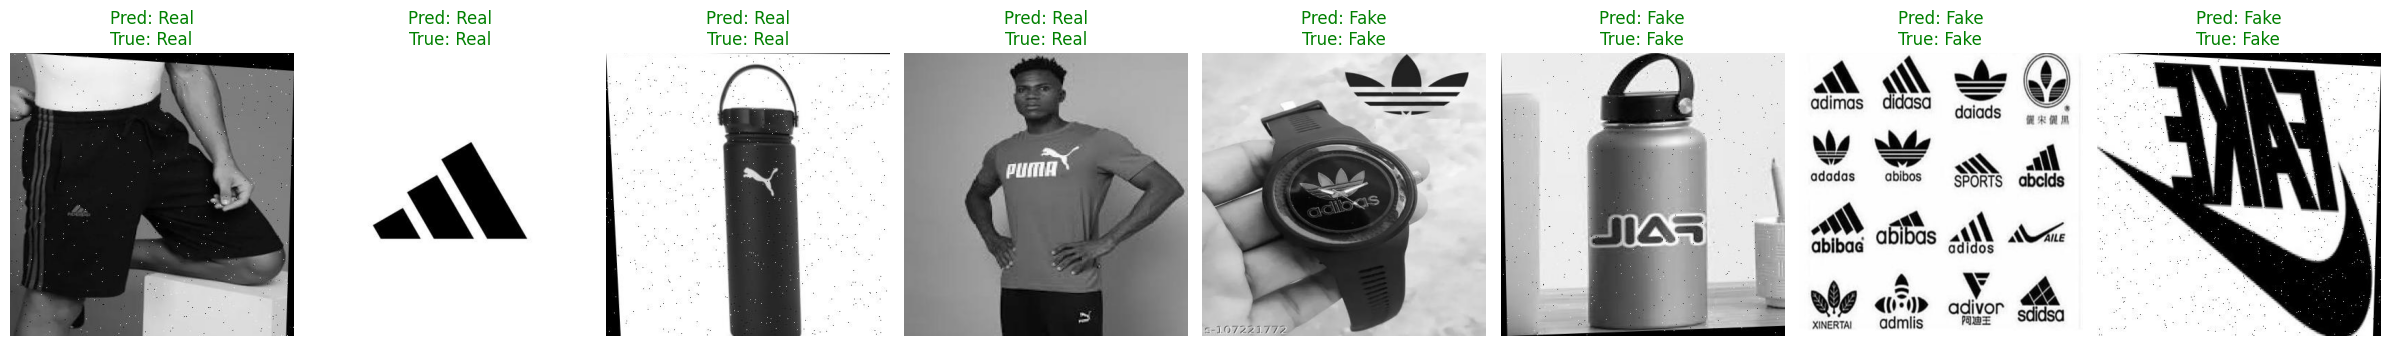

In [6]:
import matplotlib.pyplot as plt

# ----------------------------
# Save the model
# ----------------------------
MODEL_SAVE_PATH = "clip_real_fake_classifier.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# ----------------------------
# Predict and visualize sample images from training set
# ----------------------------
def show_predictions(model, dataset, num_samples=8):
    model.eval()
    correct_real = []
    correct_fake = []

    attempts = 0
    max_attempts = 10 * num_samples  # avoid infinite loop

    while len(correct_real) + len(correct_fake) < num_samples and attempts < max_attempts:
        idx = torch.randint(0, len(dataset), (1,)).item()
        sample = dataset[idx]

        with torch.no_grad():
            output = model(
                sample["input_ids"].unsqueeze(0).to(device),
                sample["attention_mask"].unsqueeze(0).to(device),
                sample["pixel_values"].unsqueeze(0).to(device),
            )
            pred = output.argmax(dim=1).item()

        true_label = sample["label"].item()
        if pred == true_label:
            if true_label == 1 and len(correct_real) < num_samples // 2:
                correct_real.append((idx, pred))
            elif true_label == 0 and len(correct_fake) < num_samples // 2:
                correct_fake.append((idx, pred))

        attempts += 1

    selected = correct_real + correct_fake
    if len(selected) == 0:
        print("No correctly predicted samples found.")
        return

    fig, axs = plt.subplots(1, len(selected), figsize=(len(selected) * 3, 4))

    for i, (idx, pred) in enumerate(selected):
        sample = dataset[idx]
        image = Image.open(dataset.data.loc[idx, "filepath"]).convert("RGB")
        true_label = sample["label"].item()

        pred_str = "Real" if pred == 1 else "Fake"
        true_str = "Real" if true_label == 1 else "Fake"

        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(f"Pred: {pred_str}\nTrue: {true_str}", color="green")

    plt.tight_layout()
    plt.show()


# Show predictions on train set
show_predictions(model, train_dataset)
